$$\newcommand{\arr}[1]{\underline{\underline{#1}}}$$    
$$\newcommand{\vec}[1]{\underline{#1}}$$   
$$\require{mhchem}$$

# Stats continued and linear regression

In [ ]:
# make our plot look a little prettier 

import seaborn as sns
sns.set()

# Recap from last class

- There are multiple types of distributions depending on whether the problem is discrete and the underlying physics generating the samples
- Averaging lots of independent random variables (regardless of their distributions) tends to lead to Gaussian distributions
- We can plot and fit distributions of any type. Be careful of binning errors, and think about whether PDF or CDF is the more useful way to visualize your distribution
- If we have experimental data there are multiple ways we can fit the distribution:
    - We could fit the cumulative distribution function (just like any curve fitting)
    - We could look up estimators for the quantity we want for the specific distribution we're interested in
    - (harder, not covered) we could use maximum likelihood estimation to derive an MLE estimator for the parameters
- Estimators for quantitites we're interested in, with uncertainty on those measurements, allow us to compare distributions and forms the basis of tools like the Student t-test
- Always think about the assumption you're making with various statistic tools (distributions, etc)
    - Think about whether those assumptions are appropriate or not. 
    - It is often possible to directly sample the quantities for the assumed question and test your understanding/interpretation
    - Common implicit assumption: all errors are Gaussian and independent and identically distributed (IID)

# Confidence intervals on samples from a Gaussian distribution

The most common thing we have to do as engineers is estimate the confidence interval from a set of repeated measurements. If we assume an unknown constant Gaussian noise is added to each data point, we want to calculate the 95% confidence interval. 

You now have the tools to calculate this. You can also do this more simply with scipy.stats.norm.interval.

In [5]:
import numpy as np 

rng = np.random.default_rng()
samples = rng.normal(0.2, 1.2, 100)

from scipy import stats

stats.norm.interval(alpha = 0.95,
                    loc = samples.mean(),
                    scale = samples.std()/np.sqrt(len(samples)))
                    

(0.004418275090167456, 0.4721634801676413)

You are welcome to use this to check your results on the homework! 

Don't be afraid to test whether your interpretation is correct by direct sampling. 

The interpretation is "if we assume this data came from a gaussian distribution with the mean/std estimated from our data and we repeated the sampling, there is a 95% chance that the new estimated mean would be within this range".

# Linear Regression 

This section is partially adapted from the 06-623 lecture notes. 

I am sure you all have fit linear curves through experimental data. We will briefly review this, show that it is a linear algebra problem you can solve, and then show you can do the same thing with linear combinations of non-linear functions. 




# Linear regression



In linear regression, we seek to find models in the form $y = a_{0} f_{0}(x) + a_{1} f_{1}(x) + ... + a_{n} f_{n}(x) + \epsilon$, where $a_{i}$ are coefficients to be determined, and &epsilon; are the residual errors. We call this linear regression because the model is linear in the unknown coefficients $a_{i}$. The functions can be any function of $x$.

If we are given some data as pairs of (x, y), we can construct a set of equations of the form:

$[f_{0}(x_{i}), f_{1}(x_{i}), ..., f_{n}(x_{i})]\cdot[a_{0}, a_{1}, ...,  a_{n}]^T = y_{i}$

There will be one of these equations for every data point, so we end up with a matrix equation that looks like:

$\arr{X} \vec{a} = \vec{y}$

There are *usually* more data points than in the vector of $\mathbf{a}$, so the shapes of these arrays are not suitable to solve directly. 

To be a little more specific, suppose we have $m$ pairs of (x, y) data points, and we want to fit a model containing $n$ parameters. Then, the dimensions of the $\arr{X}$ will be (m, n), the dimensions of $\vec{a}$ will be (n, 1), and the dimensions of $\vec{y}$ will be (m, 1).  We have more equations than unknowns here, and we cannot use `np.linalg.solve(X,y)` because $\arr{X}$ is not square. 

We can modify the equation though if we *left multiply* each side of the equation by $\arr{X}^T$.

$\arr{X}^T \arr{X} \vec{a} = \arr{X}^T \vec{y}$

The array $\arr{X}^T \arr{X}$ now has the shape (n, m) \* (m, n) = (n, n). The right hand side $\arr{X}^T \vec{y}$ has a shape of (n, m) \* (n, 1) = (n, 1), and $\mathbf{a}$ is still (n, 1). This new matrix equation can be solved efficiently with `A\b`. We will not prove this, but solving this modified equation *is equivalent* to finding the set of parameters that minimizes the summed squared errors: $\sum (\arr{X}^T\arr{X} \cdot \vec{a} - \arr{X}^T\vec{y})^2$.

The parameters can then be found by linear algebra. Let's do this for our example. 



# Example for polynomial fitting using linear regression

Let's start with some sample data collected from an experimental reactor.

Text(0, 0.5, 'Concentration $C_A$')

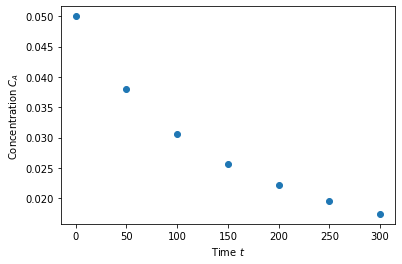

In [6]:
import matplotlib.pyplot as plt

time = np.array([0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0])
Ca = np.array([50.0, 38.0, 30.6, 25.6, 22.2, 19.5, 17.4])*1e-3

plt.plot(time,Ca,'o')
plt.xlabel('Time $t$')
plt.ylabel('Concentration $C_A$')

Fit a fourth order polynomial to this data and determine the confidence interval for each parameter. This data is from example 5-1 in Fogler, Elements of Chemical Reaction Engineering.


## Linear regression (polynomial order 1)

Let's start with the relatively easy case of fitting $C_a(t) = b_0 + b_1t$, where $b_0,b_1$ are the parameters we're trying to fit. This is equivalent to the linear algebra problem 
\begin{align*}
\vec{y}=\arr{X}\vec{b}
\end{align*}
where the first column of $X$ is 1, and the second column is $t$. This becomes a little more obvious if we just look at the data!


In [7]:
X = np.array([time**0, time**1]).T

print(X)

[[  1.   0.]
 [  1.  50.]
 [  1. 100.]
 [  1. 150.]
 [  1. 200.]
 [  1. 250.]
 [  1. 300.]]


Imagine multiplying this matrix by a vector $\vec{b}$. The first entry would be $b_0+b_10=b_0$. The second row would be $b_0+b_150$ etc. Now, we are going to form the linear algebra problem 

$\arr{X}^T \arr{X} \vec{b} = \arr{X}^T \vec{y}$

And then solve this!

In [8]:
b = np.linalg.solve(X.T@X, X.T@Ca)

print(b)

[ 0.04438571 -0.00010229]


This is the best possible linear fit for our system, and we did it with linear algebra! Let's plot it.

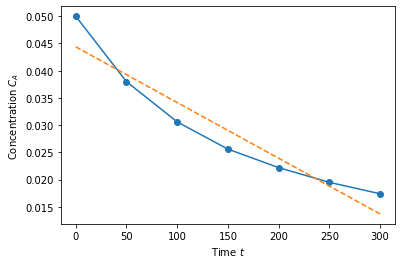

In [9]:
plt.plot(time,Ca,'o-')
plt.plot(time, b[0]+time*b[1],'--')
plt.xlabel('Time $t$')
plt.ylabel('Concentration $C_A$')
plt.show()

## Polynomial fit (fourth order)

Now here is the really cool thing: we can do this for more complicated functions too as long as it's a linear combination. Let's try a fourth order fit. 

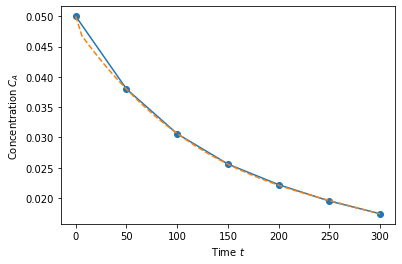

In [24]:
X = np.array([time**0, time**1, time**2, time**3, np.exp(-time)]).T
b = np.linalg.solve(X.T@X, X.T@Ca)

# Calculate the fitted polynomial at 50 points between 0 and 300
time_eval = np.linspace(0, 300)
X_eval = np.array([time_eval**0, time_eval**1, time_eval**2, time_eval**3, np.exp(-time_eval)]).T

# Plot the results
plt.plot(time,Ca,'o-')
plt.plot(time_eval, X_eval@b,'--')
plt.xlabel('Time $t$')
plt.ylabel('Concentration $C_A$')
plt.show()

In [ ]:
b

array([ 4.82000000e-02, -2.37761905e-04,  7.10000000e-07, -8.66666667e-10,
        1.80000000e-03])

The function itself is obviously non-linear. However, because it is a linear combination of non-linear things, we can do this. We could add whatever basis functions we want into this if we wanted!

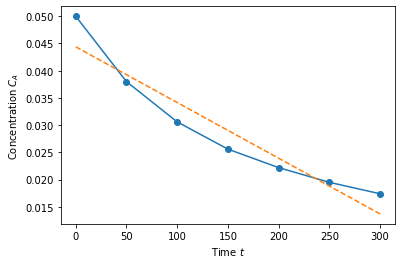

In [14]:
X = np.array([time**0, time**1]).T
b = np.linalg.solve(X.T@X, X.T@Ca)

# Calculate the fitted polynomial at 50 points between 0 and 300
time_eval = np.linspace(0, 300)
X_eval = np.array([time_eval**0, time_eval**1]).T

# Plot the results
plt.plot(time,Ca,'o-')
plt.plot(time_eval, X_eval@b,'--')
plt.xlabel('Time $t$')
plt.ylabel('Concentration $C_A$')
plt.show()

In [ ]:
b

array([ 0.04438571, -0.00010229])

Here we can see that the best fit actually includes a little bit of the log function. 

## Linear regresion minimizes the sum squared error

I claimed that solving this equation was equivalent to minimizing the summed squared errors. Here we demonstrate that is consistent with our observation for the first parameter.




Text(0, 0.5, 'SSE')

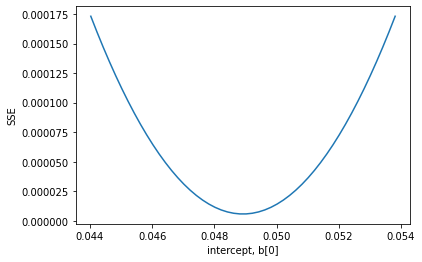

In [11]:
X = np.array([time**0, time**1, time**2]).T
b = np.linalg.solve(X.T@X,X.T@Ca)

P = np.linspace(0.9*b[0],1.1*b[0])
b_copy = b.copy()

errors = []
for p in P:
    b_copy[0]=p
    error = np.sum((Ca-X@b_copy)**2.)
    errors.append(error)
    
plt.plot(P,errors)

plt.xlabel('intercept, b[0]')
plt.ylabel('SSE')

In [12]:
b

array([ 4.89214286e-02, -2.11142857e-04,  3.62857143e-07])

In [ ]:
print(b)

[ 4.98714286e-02 -2.74476190e-04  9.32857143e-07 -1.26666667e-09]


The minimum in the sum square error is precisely at the bottom of this well!

## Metrics to evaluate how well two models fit



-   The error in the fit is defined as: $\bf{e} = \bf{y} - \bf{X}\cdot \bf{p}$

-   We can compute the summed squared error as $SSE = \bf{e} \cdot \bf{e}$
-   We define $SST = \sum (\bf{y} - \overline{y})^2 = (\bf{y} - \overline{y})\cdot(\bf{y} - \overline{y})$

-   We can use that to compute $R^2 = 1 - SSE/SST$ which roughly corresponds to the fraction of variance in the data explained by the model.

- Other common metrics include the root mean squared error, and the mean absolute error. 
-   Let us calculate each of these

In [25]:

y = Ca
e = Ca - np.dot(X,b)
SSE = np.dot(e, e)

yb = y - np.mean(y)
SST = np.dot(yb, yb)

Rsq = 1-SSE/SST

print('R^2 = %1.5f'%Rsq)

mean_absolute_error = np.mean(np.abs(e))

print('Mean absolute error = %1.6f'%mean_absolute_error)

root_mean_squared_error = np.sqrt(np.mean(e**2))

print('RMSE = %1.6f'%root_mean_squared_error)

R^2 = 0.99997
Mean absolute error = 0.000043
RMSE = 0.000054


We also made an assumption (implicitly) that the errors were Gaussian distributed and random. It's good to check that this is in fact the case. If the residuals do not look gaussian distributed and random, you are probably missing additional physics/effects/etc.

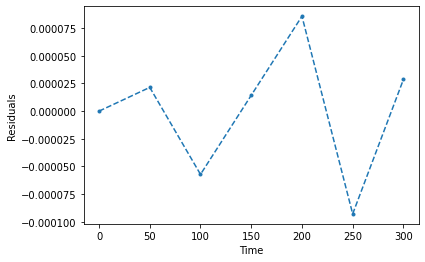

In [26]:
plt.plot(time,e,'.--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

R^2 = 0.90734
Mean absolute error = 0.002857
RMSE = 0.003269


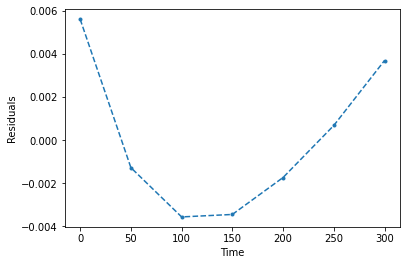

In [27]:
X = np.array([time**0, time**1]).T
b = np.linalg.solve(X.T@X,X.T@Ca)

y = Ca
e = Ca - np.dot(X,b)
SSE = np.dot(e, e)

yb = y - np.mean(y)
SST = np.dot(yb, yb)

Rsq = 1-SSE/SST

print('R^2 = %1.5f'%Rsq)

mean_absolute_error = np.mean(np.abs(e))

print('Mean absolute error = %1.6f'%mean_absolute_error)

root_mean_squared_error = np.sqrt(np.mean(e**2))

print('RMSE = %1.6f'%root_mean_squared_error)

plt.plot(time,e,'.--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Confidence intervals on parameters in linear regression

The confidence intervals reflect the range of values we are confident the true parameter lies in. Remember we are only *estimating* these parameters from a small amount of data.

The assumption is basically that there is an unknown amount of gaussian noise that is being added to the fitted model to generate the data. Because of this noise, we will obtain a different estimate of the parameters $p$ every time we run the experiment. So, similar to how we estimated the mean and the variance of the estimate above, we can do something similar for the parameters here. 

The statistics is not so complicated, but it is complicated enough that I would suggest just using a good statistical package to do it for you. For linear really models, I really like [statsmodels](https://www.statsmodels.org/stable/index.html)


In [28]:
# Install the statsmodels toolbox 
!pip install statsmodels

In [30]:
import statsmodels.api as sm

X = np.array([time**0, time**1]).T

mod = sm.OLS(Ca, X)
res = mod.fit()

res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     48.96
Date:                Tue, 26 Apr 2022   Prob (F-statistic):           0.000918
Time:                        13:27:11   Log-Likelihood:                 30.131
No. Observations:                   7   AIC:                            -56.26
Df Residuals:                       5   BIC:                            -56.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0444      0.003     16.843      0.000       0.038       0.051
x1            -0.0001   1.46e-05     -6.997      0.001      -0.000   -6.47e-05
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.943
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.729
Skew:                           0.552   Prob(JB):                        0.695
Kurtosis:                       1.869   Cond. No.                         325.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
import statsmodels.api as sm

X = np.array([time**0, time**1, time**2, time**3, time**4, time**5]).T

mod = sm.OLS(Ca, X)
res = mod.fit()

res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.590e+04
Date:                Thu, 06 May 2021   Prob (F-statistic):            0.00472
Time:                        13:11:03   Log-Likelihood:                 63.005
No. Observations:                   7   AIC:                            -114.0
Df Residuals:                       1   BIC:                            -114.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0500   7.89e-05    633.581      0.001       0.049       0.051
x1            -0.0003   8.24e-06    -36.838      0.017      -0.000      -0.000
x2          1.508e-06   2.11e-07      7.164      0.088   -1.17e-06    4.18e-06
x3         -5.052e-09   1.92e-09     -2.627      0.232   -2.95e-08    1.94e-08
x4          9.697e-12   7.26e-12      1.336      0.409   -8.26e-11    1.02e-10
x5         -8.001e-15   9.65e-15     -0.829      0.559   -1.31e-13    1.15e-13
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.713
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.235
Skew:                          -0.164   Prob(JB):                        0.889
Kurtosis:                       2.165   Cond. No.                     2.64e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This gives us tons of information. The most important is the 95% confidence intervals for each parameter. Note that the estimate for the parameters is exactly the same as the one we found above!



In [32]:
res.cov_params()

array([[ 6.94491837e-06, -3.20534694e-08],
       [-3.20534694e-08,  2.13689796e-10]])

## In-class assignment

Fit a quadratic polynomial ($y=ax^2 +bx +c$) to the following data manually.

Then, fit it with statsmodels and get the uncertainty in the final parameters.

Check the coefficient on the quadratic term; is it clear if the quadratic term is actually necessary?


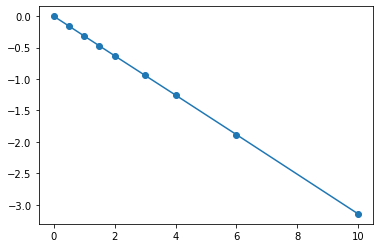

In [35]:
x = np.array([0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 6.0, 10])
y = np.array([0, -0.157, -0.315, -0.472, -0.629, -0.942, -1.255, -1.884, -3.147])


plt.plot(x,y,'o-')

In [36]:
import statsmodels.api as sm

X = np.array([x**0, x**1, x**2]).T

mod = sm.OLS(y, X)
res = mod.fit()

res.summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.042e+06
Date:                Tue, 26 Apr 2022   Prob (F-statistic):           4.09e-19
Time:                        13:37:10   Log-Likelihood:                 51.242
No. Observations:                   9   AIC:                            -96.48
Df Residuals:                       6   BIC:                            -95.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.700      0.140      -0.003       0.000
x1            -0.3131      0.000   -829.147      0.000      -0.314      -0.312
x2            -0.0001   3.69e-05     -3.987      0.007      -0.000   -5.69e-05
==============================================================================
Omnibus:                        3.557   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                0.990
Skew:                           0.013   Prob(JB):                        0.610
Kurtosis:                       1.376   Cond. No.                         78.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
import statsmodels.api as sm

X = np.array([x**0, x**1]).T

mod = sm.OLS(y, X)
res = mod.fit()

res.summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.584e+06
Date:                Tue, 26 Apr 2022   Prob (F-statistic):           9.52e-21
Time:                        13:38:55   Log-Likelihood:                 45.417
No. Observations:                   9   AIC:                            -86.83
Df Residuals:                       7   BIC:                            -86.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.738      0.485      -0.001       0.003
x1            -0.3145      0.000  -1607.619      0.000      -0.315      -0.314
==============================================================================
Omnibus:                        0.655   Durbin-Watson:                   1.353
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.585
Skew:                           0.450   Prob(JB):                        0.747
Kurtosis:                       2.136   Cond. No.                         6.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Summary

- We showed that linear regression (fitting a linear combination of functions) is essentially a linear algebra problem
    - First we find the augmented matrix, where each row is a datapoint and each column is a feature (1, X, logx, etc)
    - Then we solve $\arr{X}^T \arr{X} \vec{a} = \arr{X}^T \vec{y}$
    - This solution is the one that minimizes the sum squared error
- If we want parameter estimates, then it's probably best to use a package like statsmodel. 
